In [1]:
import random
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#!git clone https://github.com/santmarti/SDIC-Code.git
#%cd SDIC-Code/notebooks

In [3]:
from Environment import Environment
from Plotting import plotQ

In [4]:
env = Environment("CliffWalking")

env.reset()
env.render()
for a in [0,1]:
    env.step(a)
    env.render()


Setting default max_steps per episode: 100000
CliffWalking--1ag Discrete Action Space with Discrete(4)
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [5]:
def policy_random():
    return env.action_space.sample()

def policy_epsilon(state, epsilon, q_values):
    return 0

In [6]:
class Q_function():  
    # stores the Q_function Q(s,a) = "future reward" as a dictionnary:
    # Q(s) = [ reward per action ]
    # either as a table (or function approximation, next notebook)    
    # stores the number of actions of the agent needed to add a new output 

    def __init__(self, env):       
        self.nactions = env.action_space.n
        self.f = {}
        
    def predict(self, s, a=None):
        if s not in self.f:
             self.f[s] = [0]*self.nactions       
        return self.f[s] if a is None else self.f[s][a]
    
    def update(self, s, a, y):
        self.f[s][a] = y
    
    def size(self):
        return len(self.f)


In [7]:
def print_info(n, i_episode, num_episodes, epsilon, sum_rew, Q=None, steps=None):
    if(i_episode == 0): 
        print(str(i_episode)," Starting learning running ",num_episodes," episodes plotting every ", int(n)," episodes")  
        return 
    if(epsilon < 0):
        print(i_episode,"   Mean Reward: ",sum_rew)
    else:
        str_steps = "" if steps is None else " Steps: "+str(steps)
        str_Q = "" if Q is None else " Q states: "+str(Q.size())
        print(i_episode, " epsilon: %.1f"%epsilon, "   Mean Reward: %.1f"%sum_rew, str_steps, str_Q)


In [8]:
def Q_learning(env, learning_rate=0.3, discount_factor=0.9, num_episodes=5000, num_episodes_end=4000):   
    np.random.seed() 
    env.history = {"episode_rew":[], "episode_steps":[]}
    Q =  Q_function(env)
    mean_rew, mean_steps = 0, 0

    for i_episode in range(num_episodes):
        epsilon = max(1 - (1/num_episodes_end) * i_episode, 0)        
        state = env.reset()
        done = False
        sum_reward, steps = 0, 0
        while not done:
            q_values = Q.predict(state)
            if np.random.uniform() < epsilon:
                action = np.random.randint(env.nactions)   # explore
            else:
                action = np.argmax(q_values)  # exploit

            state_new, reward, done, _ = env.step(action)
            sum_reward += reward
            td_error = reward + discount_factor*np.max(Q.predict(state_new)) - q_values[action]
            td_target = q_values[action] + learning_rate*td_error
            Q.update(state,action,td_target)
            state = state_new
            steps += 1

        env.history["episode_rew"] += [sum_reward]
        env.history["episode_steps"] += [steps]
        mean_rew += sum_reward
        mean_steps += steps
        
        n = num_episodes / 20
        if (i_episode+1) % n == 0:
            print_info(n, i_episode, num_episodes, epsilon, mean_rew/n, steps=mean_steps/n, Q=Q)
            mean_rew, mean_steps = 0, 0

    return Q 

49  epsilon: 0.9    Mean Reward: -108.1  Steps: 9.08  Q states: 30
99  epsilon: 0.9    Mean Reward: -112.4  Steps: 13.4  Q states: 38
149  epsilon: 0.8    Mean Reward: -110.8  Steps: 11.84  Q states: 38
199  epsilon: 0.8    Mean Reward: -110.1  Steps: 11.1  Q states: 39
249  epsilon: 0.7    Mean Reward: -108.8  Steps: 11.74  Q states: 48
299  epsilon: 0.7    Mean Reward: -111.8  Steps: 14.78  Q states: 48
349  epsilon: 0.6    Mean Reward: -114.6  Steps: 15.58  Q states: 48
399  epsilon: 0.6    Mean Reward: -115.0  Steps: 19.94  Q states: 48
449  epsilon: 0.5    Mean Reward: -106.5  Steps: 19.42  Q states: 48
499  epsilon: 0.4    Mean Reward: -107.5  Steps: 22.34  Q states: 48
549  epsilon: 0.4    Mean Reward: -97.5  Steps: 22.3  Q states: 48
599  epsilon: 0.3    Mean Reward: -90.3  Steps: 26.96  Q states: 48
649  epsilon: 0.3    Mean Reward: -89.9  Steps: 24.6  Q states: 48
699  epsilon: 0.2    Mean Reward: -68.8  Steps: 25.26  Q states: 48
749  epsilon: 0.2    Mean Reward: -58.3  Step

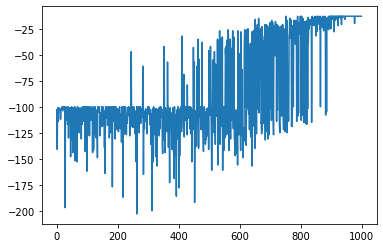

In [9]:
params = {"learning_rate":0.1, "discount_factor":0.8, "num_episodes":1000, "num_episodes_end":900}
q_func = Q_learning(env, **params)

plt.plot(env.history["episode_rew"])

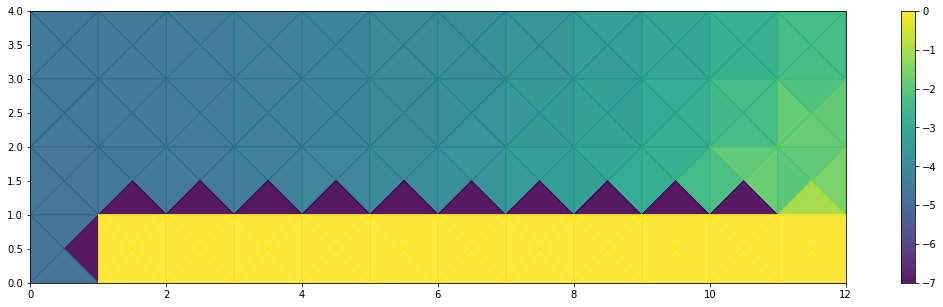

In [10]:
plotQ(env, q_func, min_max=[-7,0])

In [11]:
def policy(state, epsilon, q_values):
    if random.uniform(0, 1) < epsilon:
        return env.action_space.sample()   # Explore action space
    else:
        return np.argmax(q_values)

    
def SARSA_learning(env, learning_rate=0.3, discount_factor=0.9, num_episodes=1000, num_episodes_end=900):
    epsilon_ini = 1    
    np.random.seed() 
    env.history = {"episode_rew":[], "episode_steps":[]}
    
    Q =  Q_function(env)
    
    sum_rew_epi, steps = 0, 0
        
    for i_episode in range(num_episodes):
        
        epsilon = max(1 - (1/num_episodes_end) * i_episode, 0)        
        
        state = env.reset()
        action = policy(state, epsilon, Q.predict(state))
                     
        steps, sum_rew_epi, done = 0, 0, False
        while done != True:
            q_values = Q.predict(state)    
            
            next_state, reward, done, info = env.step(action)  
            next_action = policy(next_state, epsilon, q_values)
            next_q_value = Q.predict(next_state)[next_action]
            
            sum_rew_epi += reward

            td_target = q_values[action] + learning_rate * (reward + discount_factor * next_q_value - q_values[action])   
            Q.update(state, action, td_target)
            
            state = next_state
            action = next_action    
            steps += 1
            
        env.history["episode_rew"].append(sum_rew_epi)
        env.history["episode_steps"].append(steps)
         
    return Q 

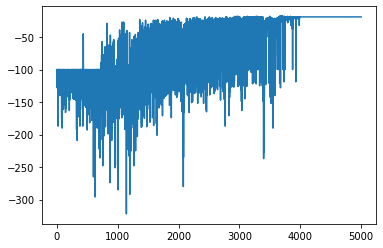

In [12]:
# Careful with the discount factor for SARSA it may not converge if < 1
# Reason being: as SARSA being on-policy and risc averse, if we act greedy with respect to reward it does not converge

params = {"learning_rate":0.1, "discount_factor":1.0, "num_episodes":5000, "num_episodes_end":4000}
q_func_sarsa = SARSA_learning(env, **params)
plt.plot(env.history["episode_rew"])

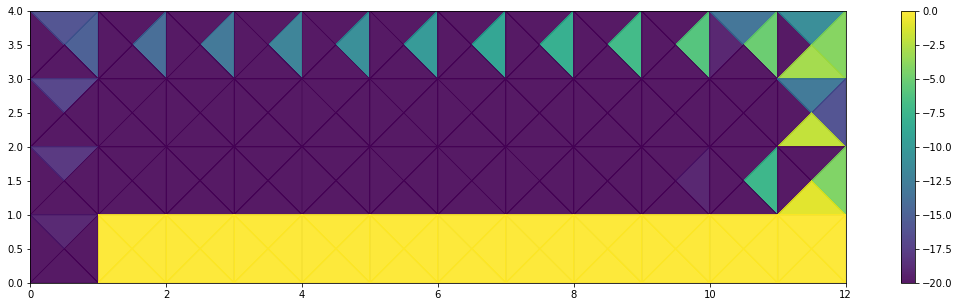

In [13]:
plotQ(env, q_func_sarsa, min_max=[-20,0])